# BARRA/ERA5 climatology

In [1]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.gridspec import GridSpec
sys.path.append('/g/data/qz03/wp3/code/git-repo')
from utils import *

In [2]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [3]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41895,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:36117,Total threads: 1
Dashboard: /proxy/45361/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:42537,


In [41]:
%%time
barra_winds_dly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/BARRAR2/day/sfcWind/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).compute()
barra_pr_dly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/BARRAR2/day/pr/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).compute()
barra_rsds_dly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/BARRAR2/day/rsds/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).compute()

CPU times: user 22.6 s, sys: 22.3 s, total: 44.9 s
Wall time: 56.5 s


In [114]:
%%time
#rolling monthly
barra_winds_mth = barra_winds_dly.sortby('time').resample(time='1M').mean()
barra_pr_mth = (barra_pr_dly*86400).sortby('time').resample(time='1M').sum()
barra_rsds_mth = (barra_rsds_dly*0.024).sortby('time').resample(time='1M').sum()

#monthly climos
barra_winds_mth_climo = (barra_winds_dly.groupby('time.month')).mean()
barra_pr_mth_climo = (barra_pr_mth.groupby('time.month')).mean()
barra_rsds_mth_climo = (barra_winds_mth.groupby('time.month')).mean()

CPU times: user 1min 21s, sys: 55.5 s, total: 2min 17s
Wall time: 1min 54s


### Spatial plots

In [47]:
def plot_climo(plot_type, input_climo_xr, plot_var, cmap, vmin, vmax, cbar_extend, cbar_label, plot_title):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    sys.path.append('/g/data/qz03/wp3/code/git-repo')
    from utils import domain_dict
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_array = input_climo_xr[plot_var]
    
    contour = plot_array.plot.imshow(ax=ax, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False) if plot_type =='raster' else plot_array.plot.contourf(ax=ax, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap, levels=((vmax-vmin)*2)+1, add_colorbar=False)
    cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.07, shrink=0.6, extend=cbar_extend, label=cbar_label)
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(plot_title, fontsize=14, pad=12)
    ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'], domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())
    
    plt.tight_layout()
    plt.show()
    return

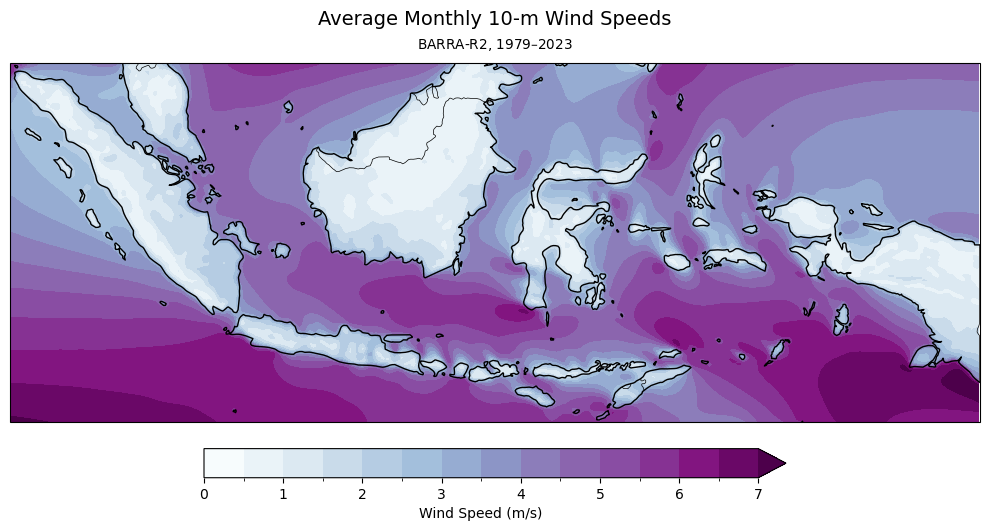

In [77]:
plot_climo('contour', barra_winds_mth.mean(dim='time'), 'sfcWind', 'BuPu', 0, 7, 'max', 'Wind Speed (m/s)', 'Average Monthly 10-m Wind Speeds\n$_{\\text{BARRA-R2, 1979–2023}}$')

In [165]:
climo_dict = {}
climo_dict['All_months-10-m_winds'] = barra_winds_mth.mean(dim='time')
climo_dict['Dry_season_months-10-m_winds'] = barra_winds_mth.sel(time=barra_winds_mth.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])).mean('time')
climo_dict['Wet_season_months-10-m_winds'] = barra_winds_mth.sel(time=barra_winds_mth.time.dt.month.isin([11, 12, 1, 2, 3])).mean('time')

climo_dict['All_months_months-rainfall'] = barra_pr_mth.mean(dim='time')
climo_dict['Dry_season_months-rainfall'] = barra_pr_mth.sel(time=barra_pr_mth.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])).mean('time')
climo_dict['Wet_season_months-rainfall'] = barra_pr_mth.sel(time=barra_pr_mth.time.dt.month.isin([11, 12, 1, 2, 3])).mean('time')

climo_dict['All_months-surface_downwelling_radiation'] = barra_rsds_mth.mean(dim='time')
climo_dict['Dry_season_months-surface_downwelling_radiation'] = barra_rsds_mth.sel(time=barra_rsds_mth.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10])).mean('time')
climo_dict['Wet_season_months-surface_downwelling_radiation'] = barra_rsds_mth.sel(time=barra_rsds_mth.time.dt.month.isin([11, 12, 1, 2, 3])).mean('time')

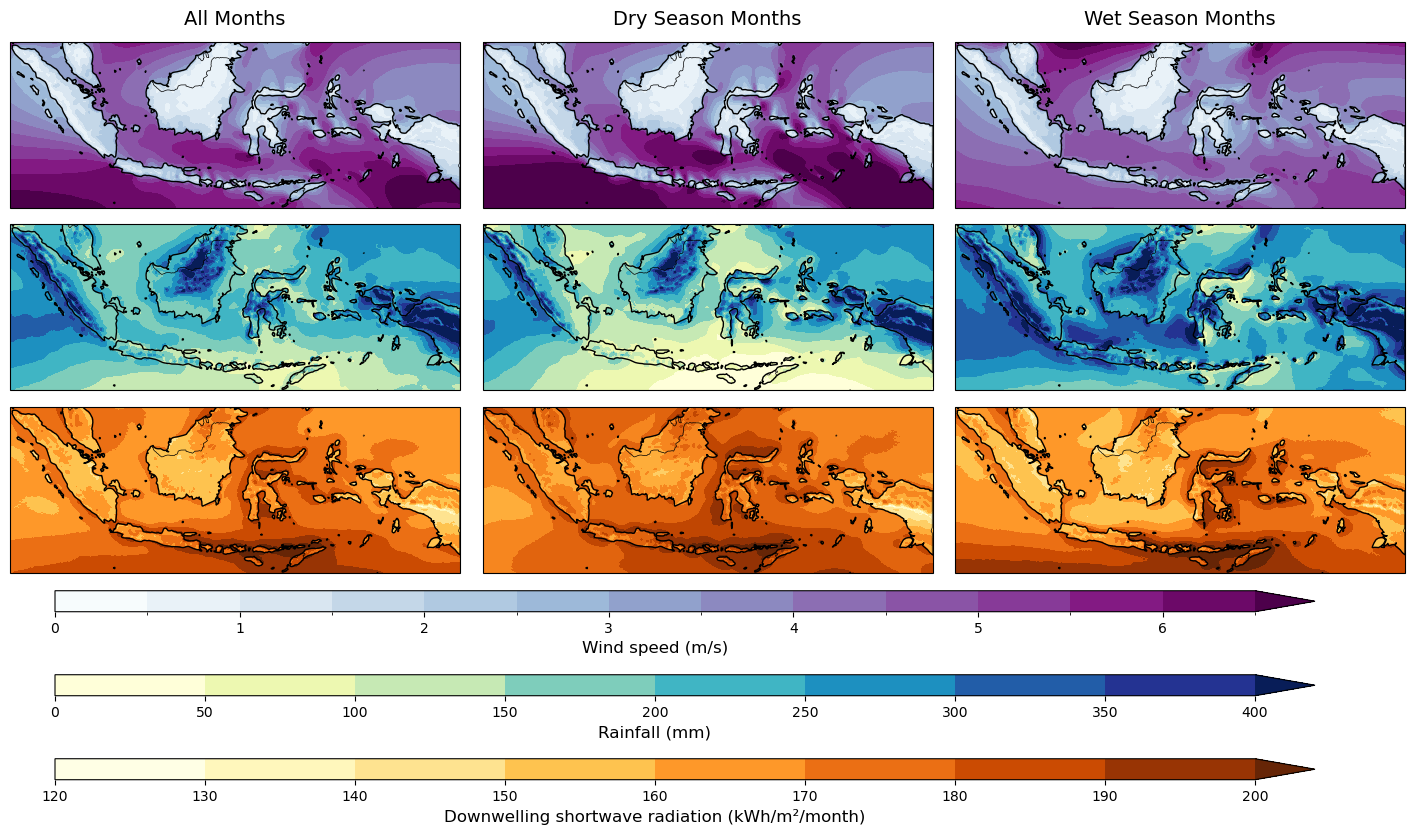

<Figure size 640x480 with 0 Axes>

In [214]:
fig = plt.figure(figsize=(18, 7))
gs = GridSpec(3, 3, figure=fig, hspace=0.05, wspace=0.05)
axes = [fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(9)]

for ax, (title, plot_data) in zip(axes, climo_dict.items()):
    if 'wind' in title:
        wind = plot_data.sfcWind.plot.contourf(ax=ax, vmin=0, vmax=6.5, levels=14, transform=ccrs.PlateCarree(), cmap='BuPu', add_colorbar=False)#.plot.contourf(ax=ax, vmin=0, vmax=7, levels=15, transform=ccrs.PlateCarree(), cmap='BuPu', add_colorbar=False)    
    elif 'rainfall' in title:
        rain = plot_data.pr.plot.contourf(ax=ax, vmin=0, vmax=400, levels=9, transform=ccrs.PlateCarree(), cmap='YlGnBu', add_colorbar=False)#.plot.contourf(ax=ax, vmin=0, vmax=7, levels=15, transform=ccrs.PlateCarree(), cmap='BuPu', add_colorbar=False)    
    elif 'radiation' in title:
        rsds = plot_data.rsds.plot.contourf(ax=ax, vmin=120, vmax=200, levels=9, transform=ccrs.PlateCarree(), cmap='YlOrBr', add_colorbar=False)#.plot.contourf(ax=ax, vmin=0, vmax=7, levels=15, transform=ccrs.PlateCarree(), cmap='BuPu', add_colorbar=False)    

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title((title.split('-')[0]).replace('_', ' ').title() if 'wind' in title else '', fontsize=14, pad=12)
    ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'],
                   domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())


cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.03]) #fig.add_axes([0.915, 0.15, 0.01, 0.7])  
cbar = fig.colorbar(wind, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Wind speed (m/s)', fontsize=12)

cbar_ax = fig.add_axes([0.15, -0.06, 0.7, 0.03])  #fig.add_axes([0.96, 0.15, 0.01, 0.7])  
cbar = fig.colorbar(rain, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Rainfall (mm)', fontsize=12)

cbar_ax = fig.add_axes([0.15, -0.18, 0.7, 0.03])  #fig.add_axes([1.01, 0.15, 0.01, 0.7])   
cbar = fig.colorbar(rsds, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Downwelling shortwave radiation (kWh/m²/month)', fontsize=12)

plt.show()
plt.clf()

### Timeseries plots

In [140]:
loc_data = barra_winds_dly.sel(lat=-5.645031, lon=119.711252, method='nearest').sortby('time')

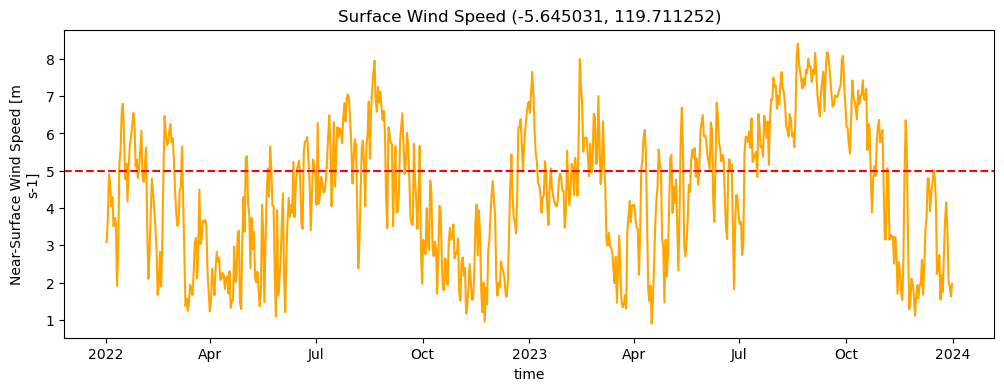

In [163]:
ax = loc_data.sel(time=slice('2022-01-01', '2024-01-01')).sfcWind.plot.line(color='orange', figsize=(12, 4))
plt.title('Surface Wind Speed (-5.645031, 119.711252)')
plt.axhline(y=5, color='red', linestyle='--')
plt.show()

### ENSO

In [231]:
def read_nino(
    url="http://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.91-20.ascii",
    ):
    """
    Read NINO data from specified web URL - assumes NOAA CPC formatting
     - old url was "http://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.81-10.ascii"
    """
    #Skip header - we will specify our own
    columns=['year','month','nino1+2','nino1+2 anom','nino3','nino3 anom','nino4','nino4 anom','nino3.4','nino3.4 anom']
    nino_data = pd.read_csv(url,skiprows=1,names=columns,delim_whitespace=True)
    #output nino3.4 anomalies in required format
    nino_data['time'] = pd.to_datetime(nino_data['year'].astype(str) + nino_data['month'].astype(str).str.zfill(2), format='%Y%m') + pd.offsets.MonthEnd(0)
    nino_data.set_index('time',inplace=True)
    # remove superfluous year, month columns
    nino_data.drop(['year','month'],axis='columns',inplace=True)
    nino_data.sort_index(inplace=True)

    return nino_data


In [232]:
nino_df = read_nino()

In [233]:
nino_df['nino3.4 anom']

time
1950-01-31   -1.99
1950-02-28   -1.69
1950-03-31   -1.42
1950-04-30   -1.54
1950-05-31   -1.75
              ... 
2024-12-31   -0.60
2025-01-31   -0.74
2025-02-28   -0.43
2025-03-31    0.01
2025-04-30   -0.16
Name: nino3.4 anom, Length: 904, dtype: float64

In [234]:
nino_df['phase'] = nino_df['nino3.4 anom'].apply(lambda x: 1 if x >= 0.8 else (-1 if x <= -0.8 else 0)) # 1 el nino # -1 la nina # 0 neutral

In [235]:
nino_df['phase'] 

time
1950-01-31   -1
1950-02-28   -1
1950-03-31   -1
1950-04-30   -1
1950-05-31   -1
             ..
2024-12-31    0
2025-01-31    0
2025-02-28    0
2025-03-31    0
2025-04-30    0
Name: phase, Length: 904, dtype: int64

In [236]:
enso_phase = xr.DataArray(data=nino_df['phase'].values, coords={'time': nino_df.index}, dims='time', name='enso')

In [241]:
 barra_winds_mth.where(enso_phase==1).mean(dim='time')

<xarray.Dataset> Size: 264kB
Dimensions:  (lat: 155, lon: 418)
Coordinates:
  * lon      (lon) float64 3kB 95.08 95.19 95.3 95.41 ... 140.7 140.8 140.9
  * lat      (lat) float64 1kB -11.0 -10.89 -10.78 -10.67 ... 5.72 5.83 5.94
    height   float64 8B 10.0
    crs      int32 4B 0
Data variables:
    sfcWind  (lat, lon) float32 259kB 7.04 7.036 7.031 ... 5.292 5.293 5.294

In [250]:
enso_dict = {}
enso_dict['Neutral_months-10-m_winds'] = barra_winds_mth.where(enso_phase==0)
enso_dict['El_Niño_months-10-m_winds'] = barra_winds_mth.where(enso_phase==1)
enso_dict['La_Niña_months-10-m_winds'] = barra_winds_mth.where(enso_phase==-1)

enso_dict['Neutral_months-rainfall'] = barra_pr_mth.where(enso_phase==0)
enso_dict['El_Niño_months-rainfall'] = barra_pr_mth.where(enso_phase==1)
enso_dict['La_Niña_months-rainfall'] = barra_pr_mth.where(enso_phase==-1)

enso_dict['Neutral_months-surface_downwelling_radiation'] = barra_rsds_mth.where(enso_phase==0)
enso_dict['El_Niño_months-surface_downwelling_radiation'] = barra_rsds_mth.where(enso_phase==1)
enso_dict['La_Niña_months-surface_downwelling_radiation'] = barra_rsds_mth.where(enso_phase==-1)

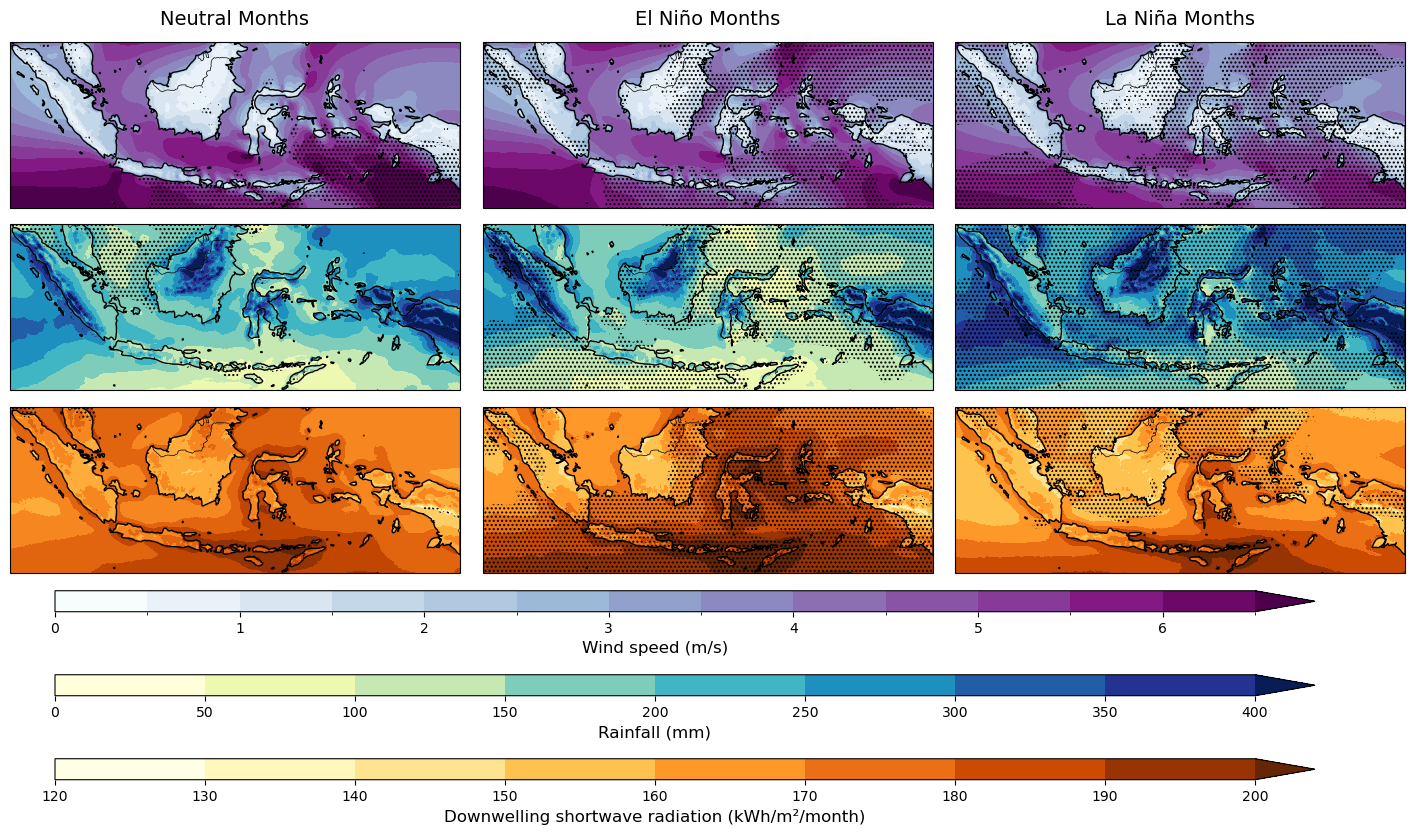

CPU times: user 12min 20s, sys: 1min 2s, total: 13min 23s
Wall time: 12min 19s


<Figure size 640x480 with 0 Axes>

In [258]:
%%time
fig = plt.figure(figsize=(18, 7))
gs = GridSpec(3, 3, figure=fig, hspace=0.05, wspace=0.05)
axes = [fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(9)]

for ax, (title, plot_data) in zip(axes, enso_dict.items()):
    lon2d, lat2d = np.meshgrid(plot_data.lon.values, plot_data.lat.values)
    if 'wind' in title:
        t_stat, p_values = ttest_ind(plot_data.sfcWind.values, barra_winds_mth.sfcWind.values, axis=0, equal_var=False, nan_policy='omit')
        significance_mask = p_values < 0.05
        wind = (plot_data.mean(dim='time')).sfcWind.plot.contourf(ax=ax, vmin=0, vmax=6.5, levels=14, transform=ccrs.PlateCarree(), cmap='BuPu', add_colorbar=False)
        ax.contourf(lon2d, lat2d, significance_mask, levels=[0.5, 1.5], hatches=['....'], colors='none', transform=ccrs.PlateCarree())
    elif 'rainfall' in title:
        t_stat, p_values = ttest_ind(plot_data.pr.values, barra_pr_mth.pr.values, axis=0, equal_var=False, nan_policy='omit')
        significance_mask = p_values < 0.05
        rain = (plot_data.mean(dim='time')).pr.plot.contourf(ax=ax, vmin=0, vmax=400, levels=9, transform=ccrs.PlateCarree(), cmap='YlGnBu', add_colorbar=False)
        ax.contourf(lon2d, lat2d, significance_mask, levels=[0.5, 1.5], hatches=['....'], colors='none', transform=ccrs.PlateCarree())
    elif 'radiation' in title:
        t_stat, p_values = ttest_ind(plot_data.rsds.values, barra_rsds_mth.rsds.values, axis=0, equal_var=False, nan_policy='omit')
        significance_mask = p_values < 0.05
        rsds = (plot_data.mean(dim='time')).rsds.plot.contourf(ax=ax, vmin=120, vmax=200, levels=9, transform=ccrs.PlateCarree(), cmap='YlOrBr', add_colorbar=False)#.plot.contourf(ax=ax, vmin=0, vmax=7, levels=15, transform=ccrs.PlateCarree(), cmap='BuPu', add_colorbar=False)    
        ax.contourf(lon2d, lat2d, significance_mask, levels=[0.5, 1.5], hatches=['....'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title((title.split('-')[0]).replace('_', ' ').title() if 'wind' in title else '', fontsize=14, pad=12)
    ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'],
                   domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())


cbar_ax = fig.add_axes([0.15, 0.06, 0.7, 0.03]) #fig.add_axes([0.915, 0.15, 0.01, 0.7])  
cbar = fig.colorbar(wind, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Wind speed (m/s)', fontsize=12)

cbar_ax = fig.add_axes([0.15, -0.06, 0.7, 0.03])  #fig.add_axes([0.96, 0.15, 0.01, 0.7])  
cbar = fig.colorbar(rain, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Rainfall (mm)', fontsize=12)

cbar_ax = fig.add_axes([0.15, -0.18, 0.7, 0.03])  #fig.add_axes([1.01, 0.15, 0.01, 0.7])   
cbar = fig.colorbar(rsds, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Downwelling shortwave radiation (kWh/m²/month)', fontsize=12)

plt.show()
plt.clf()